<a href="https://colab.research.google.com/github/cabralchege/Accoustic-Anomaly-Detection/blob/main/Acoustic_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acoustic Anomaly Detection in Industrial Pumps

In [3]:
# import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow as tf
import kagglehub
import joblib
from tqdm import tqdm

In [115]:
# ML Libraries
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_recall_curve
from tensorflow.keras import layers, models, callbacks, regularizers

### Configurations

In [46]:
# Configuration parameters
# Audio parameters
sr = 16000
duration = 10
expected_samples = sr * duration
N_FFT = 1024
hop_length = 512
N_MELS = 64        # CNN (Spectrograms)
N_MFCC = 20        # LSTM/GMM

# Plotting Style
plt.style.use('ggplot')
sns.set_context("notebook")

## Data Pre-Processing


### Data loading

In [40]:
abnormal_pump_path = "/kaggle/input/mimii-pump-sound-dataset/abnormal"
normal_pump_path="/kaggle/input/mimii-pump-sound-dataset/normal"

In [41]:
# Load the data
path = kagglehub.dataset_download("senaca/mimii-pump-sound-dataset")
abnormal_files = glob.glob(os.path.join(path, 'abnormal', '*.wav'))
normal_files = glob.glob(os.path.join(path, 'normal', '*.wav'))

print(len(normal_files))
print(len(abnormal_files))

Using Colab cache for faster access to the 'mimii-pump-sound-dataset' dataset.
381
138


In [42]:
def load_audio_files(path, label):
    audio_files = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.wav'):
            file_path = os.path.join(path, filename)
            audio, sample_rate = librosa.load(file_path, sr=None)
            audio_files.append(audio)
            labels.append(label)
    return audio_files, labels, sample_rate

# Load the datasets
abnormal_audio, abnormal_labels, _ = load_audio_files(abnormal_pump_path, label=1)
normal_audio, normal_labels, sample_rate = load_audio_files(normal_pump_path, label=0)

### Data pipeline

In [47]:
# Define data pipelines for two features MFCCs and Spectrograms
def extract_features(files):
    specs = []
    mfccs = []

    print(f"Processing {len(files)} files...")

    for f in tqdm(files):
        try:
            # Load Audio
            y, _ = librosa.load(f, sr=sr, duration=duration)

            # Truncate to ensure fixed length
            if len(y) < expected_samples:
                y = np.pad(y, (0, expected_samples - len(y)))
            else:
                y = y[:expected_samples]

            # Extract Spectrogram features
            mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=hop_length, n_mels=N_MELS)
            log_mel = librosa.power_to_db(mel, ref=np.max)
            specs.append(log_mel.T)

            # Extract MFCCs features
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
            mfccs.append(mfcc.T)

        except Exception as e:
            print(f"Error with {f}: {e}")

    return np.array(specs), np.array(mfccs)



In [48]:
# Extraction
# Normal feats
norm_specs, norm_mfccs = extract_features(normal_files[:400])
# Abnormal feats
abnorm_specs, abnorm_mfccs = extract_features(abnormal_files[:200])

print(f"Spectrogram Shape: {norm_specs.shape}")
print(f"MFCC Shape:        {norm_mfccs.shape}")

Processing 381 files...


100%|██████████| 381/381 [00:20<00:00, 18.61it/s]


Processing 138 files...


100%|██████████| 138/138 [00:10<00:00, 13.03it/s]


Spectrogram Shape: (381, 313, 64)
MFCC Shape:        (381, 313, 20)


In [49]:
# Data splitting
# Normal data split
idx_train, idx_test = train_test_split(np.arange(len(norm_specs)), test_size=0.2, random_state=42)

In [50]:
# Scaling
# Spectogram pipeline (flaten, scale, reshape)
scaler_A = MinMaxScaler()
flat_train_A = norm_specs[idx_train].reshape(-1, N_MELS)
scaler_A.fit(flat_train_A)

def scale_A(data):
    N, T, F = data.shape
    scaled = scaler_A.transform(data.reshape(-1, F))
    return scaled.reshape(N, T, F)

X_train_A = scale_A(norm_specs[idx_train])
X_test_normal_A = scale_A(norm_specs[idx_test])
X_test_abnormal_A = scale_A(abnorm_specs)


In [51]:
# Scaling
# MFCCs pipeline
scaler_B = StandardScaler()
flat_train_B = norm_mfccs[idx_train].reshape(-1, N_MFCC)
scaler_B.fit(flat_train_B)

def scale_B(data):
    N, T, F = data.shape
    scaled = scaler_B.transform(data.reshape(-1, F))
    return scaled.reshape(N, T, F)

X_train_B = scale_B(norm_mfccs[idx_train])
X_test_normal_B = scale_B(norm_mfccs[idx_test])
X_test_abnormal_B = scale_B(abnorm_mfccs)

### Data Splitting

In [52]:
# Split data to form a combined test set containing both normal and abnormal
y_test = np.concatenate([np.zeros(len(X_test_normal_A)), np.ones(len(X_test_abnormal_A))])

## Exploratory Data Analysis

### Data Exploration

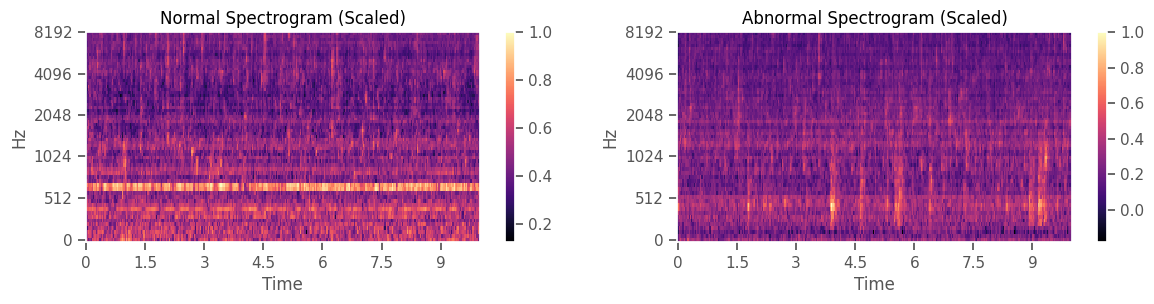

In [54]:
# Visualizations
plt.figure(figsize=(14, 6))

# Plot Spectrograms
plt.subplot(2, 2, 1)
librosa.display.specshow(X_train_A[0].T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title('Normal Spectrogram (Scaled)')
plt.colorbar()

plt.subplot(2, 2, 2)
librosa.display.specshow(X_test_abnormal_A[0].T, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title('Abnormal Spectrogram (Scaled)')
plt.colorbar()

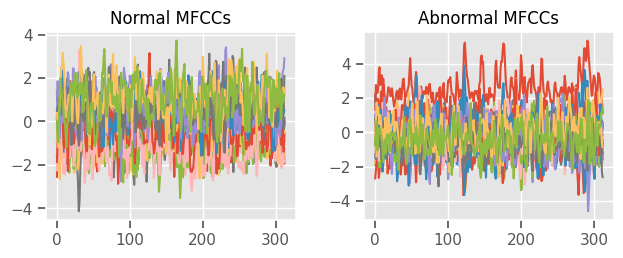

In [55]:
# Plot MFCCs
# Plot MFCCs
plt.subplot(2, 2, 3)
plt.plot(X_train_B[0])
plt.title('Normal MFCCs')

plt.subplot(2, 2, 4)
plt.plot(X_test_abnormal_B[0])
plt.title('Abnormal MFCCs')

plt.tight_layout()
plt.show()

### Data Distribution and Correlation

In [58]:
# Flaten data again to 2D for plotting
# Shape: (Samples * Time, 20 Features)
normal_feats_flat = X_train_B.reshape(-1, N_MFCC)
abnormal_feats_flat = X_test_abnormal_B.reshape(-1, N_MFCC)

In [59]:
# Place them in a dataframe
df_normal = pd.DataFrame(normal_feats_flat, columns=[f'MFCC_{i+1}' for i in range(N_MFCC)])
df_abnormal = pd.DataFrame(abnormal_feats_flat, columns=[f'MFCC_{i+1}' for i in range(N_MFCC)])


Feature distributions MFCCs

In [64]:
features_to_plot = ['MFCC_1', 'MFCC_5', 'MFCC_10']

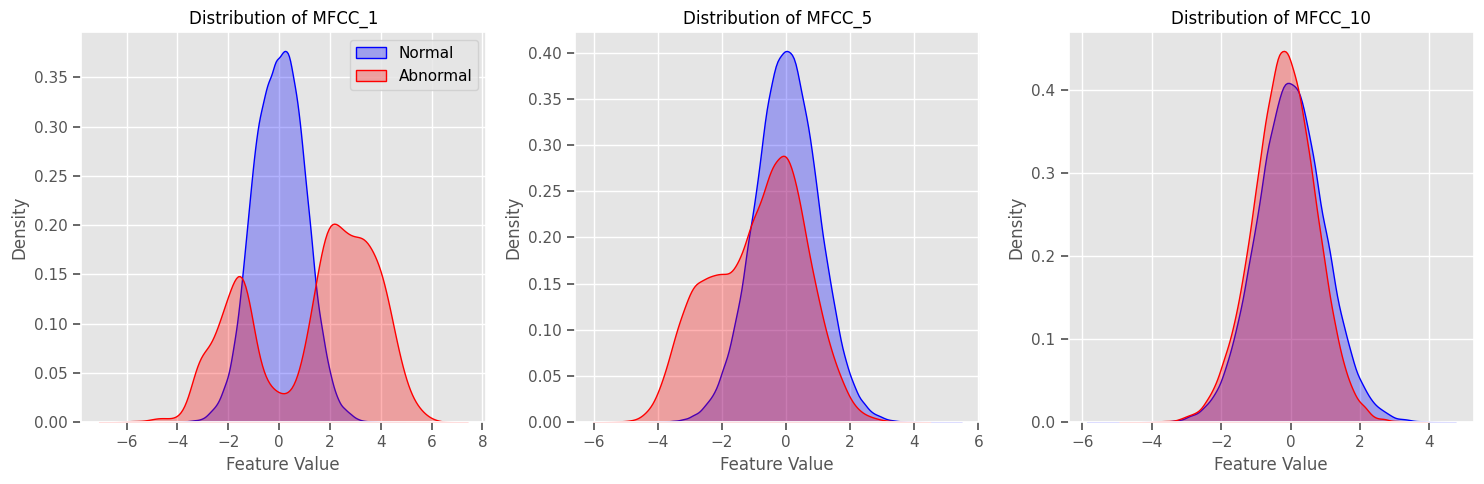

In [65]:
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(df_normal[feature], label='Normal', fill=True, color='blue', alpha=0.3)
    sns.kdeplot(df_abnormal[feature], label='Abnormal', fill=True, color='red', alpha=0.3)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Feature Value')
    if i == 0: plt.legend()

plt.tight_layout()
plt.show()

Feature Correlation MFCCs

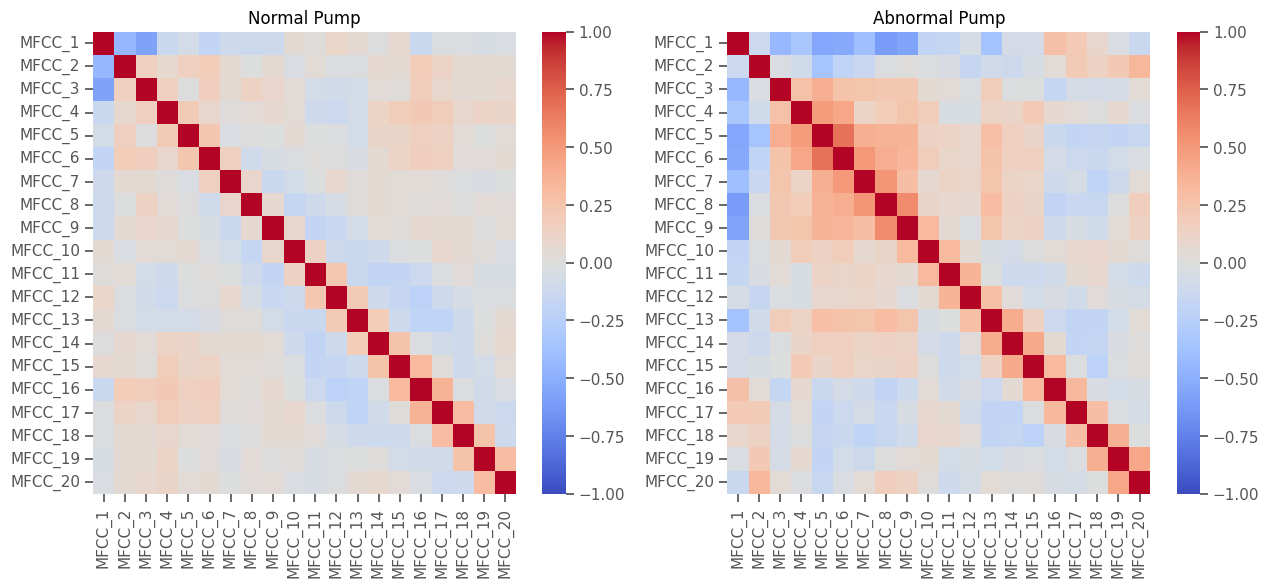

In [67]:
# Feat correlation
plt.figure(figsize=(15, 6))

# Normal Correlation
plt.subplot(1, 2, 1)
sns.heatmap(df_normal.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Normal Pump")

# Abnormal Correlation
plt.subplot(1, 2, 2)
sns.heatmap(df_abnormal.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Abnormal Pump")

plt.show()

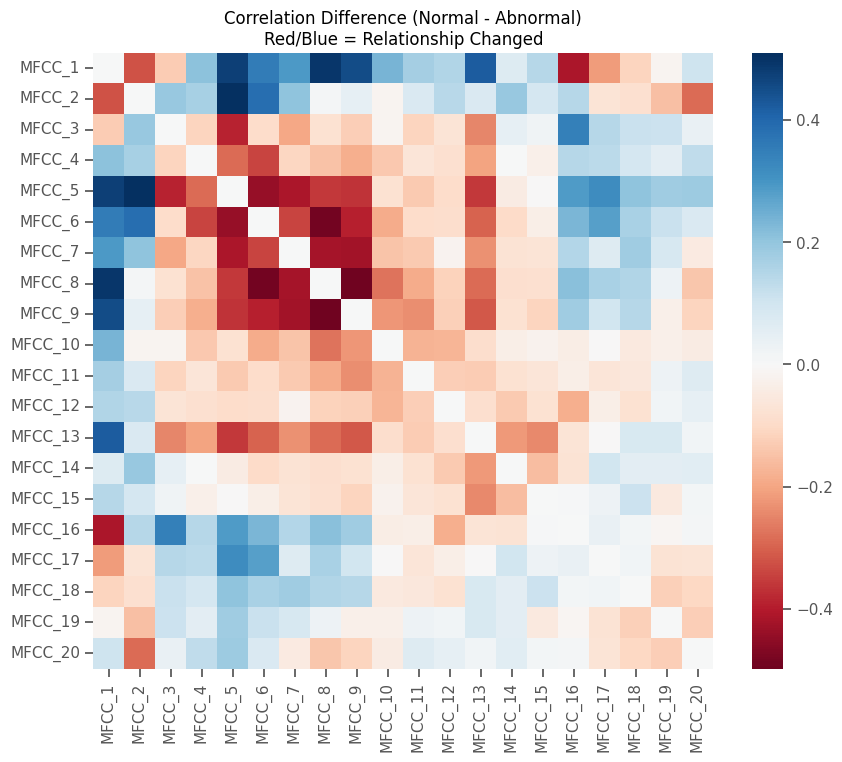

In [68]:
# Show differences in correlation by subtracting the matrices
plt.figure(figsize=(10, 8))
diff_corr = df_normal.corr() - df_abnormal.corr()
sns.heatmap(diff_corr, cmap='RdBu', center=0, annot=False)
plt.title("Correlation Difference (Normal - Abnormal)\nRed/Blue = Relationship Changed")
plt.show()

Feature Distribution Spectrogram

In [70]:
# Flatten the data
flat_norm_spec = X_train_A.reshape(-1, N_MELS)
flat_abnorm_spec = X_test_abnormal_A.reshape(-1, N_MELS)

In [71]:
# Place the data in a data frame
df_norm_spec = pd.DataFrame(flat_norm_spec, columns=[f'Freq_Bin_{i}' for i in range(N_MELS)])
df_abnorm_spec = pd.DataFrame(flat_abnorm_spec, columns=[f'Freq_Bin_{i}' for i in range(N_MELS)])

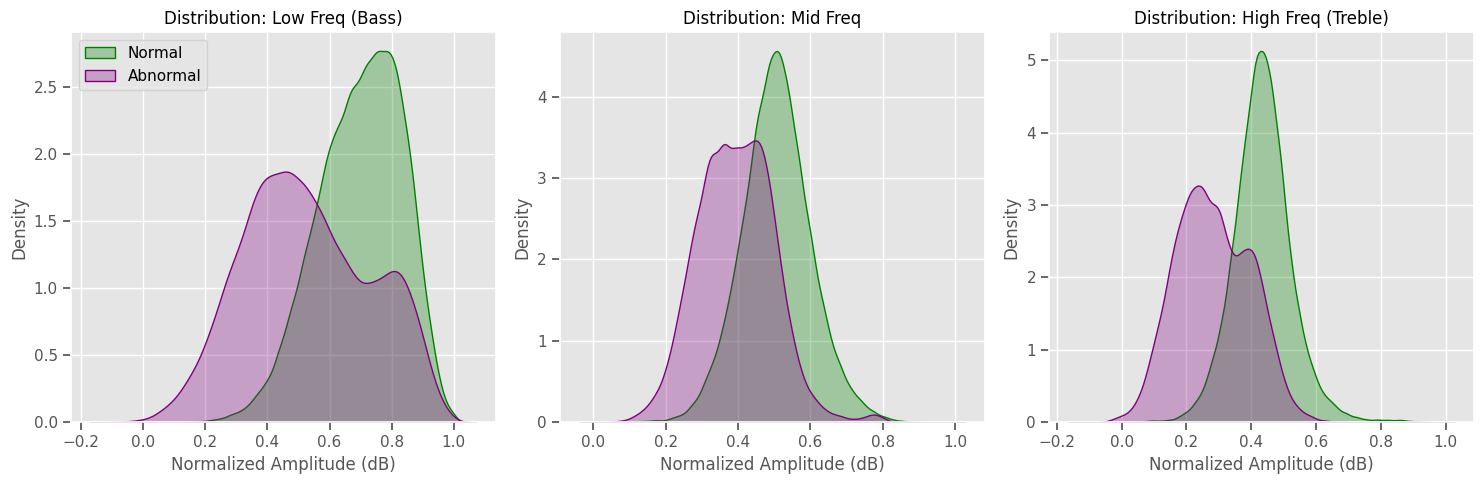

In [72]:
# Feature distribution
bins_to_check = [0, 32, 63] # Low (Bass), Mid, High (Treble)
bin_labels = ['Low Freq (Bass)', 'Mid Freq', 'High Freq (Treble)']

plt.figure(figsize=(15, 5))

for i, bin_idx in enumerate(bins_to_check):
    col_name = f'Freq_Bin_{bin_idx}'

    plt.subplot(1, 3, i+1)
    # Plot Normal vs Abnormal distributions
    sns.kdeplot(df_norm_spec[col_name], label='Normal', fill=True, color='green', alpha=0.3)
    sns.kdeplot(df_abnorm_spec[col_name], label='Abnormal', fill=True, color='purple', alpha=0.3)

    plt.title(f'Distribution: {bin_labels[i]}')
    plt.xlabel('Normalized Amplitude (dB)')
    if i == 0: plt.legend()

plt.tight_layout()
plt.show()

Feature Correlation Spectrogram

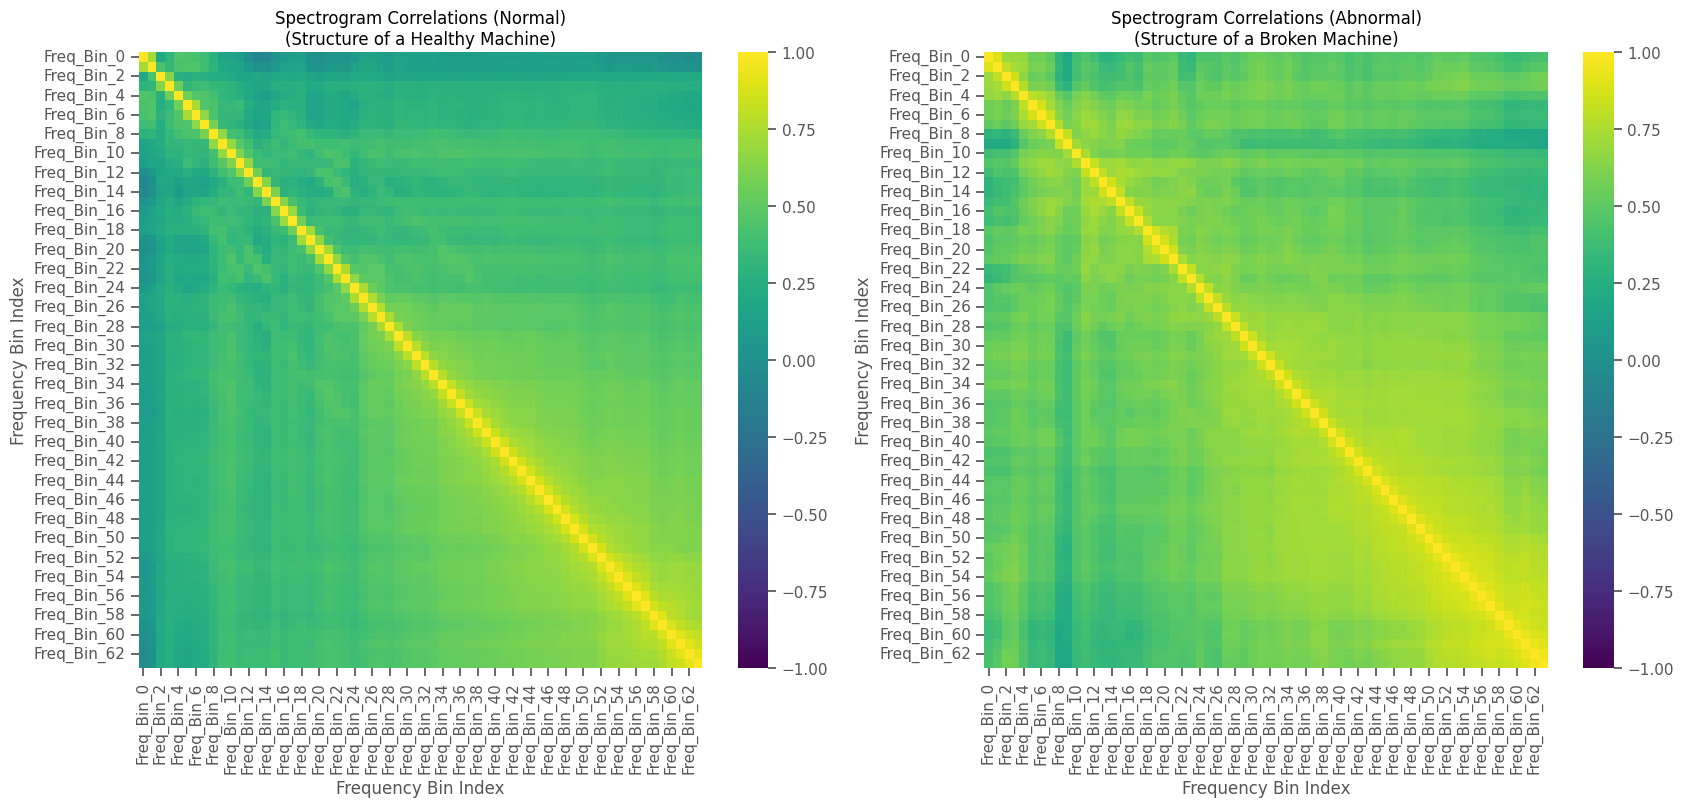

In [73]:
# Feat correalation
plt.figure(figsize=(20, 8))

# Normal Correlation
plt.subplot(1, 2, 1)
sns.heatmap(df_norm_spec.corr(), cmap='viridis', vmin=-1, vmax=1)
plt.title("Spectrogram Correlations (Normal)\n(Structure of a Healthy Machine)")
plt.xlabel("Frequency Bin Index")
plt.ylabel("Frequency Bin Index")

# Abnormal Correlation
plt.subplot(1, 2, 2)
sns.heatmap(df_abnorm_spec.corr(), cmap='viridis', vmin=-1, vmax=1)
plt.title("Spectrogram Correlations (Abnormal)\n(Structure of a Broken Machine)")
plt.xlabel("Frequency Bin Index")
plt.ylabel("Frequency Bin Index")

plt.show()

/tmp/ipython-input-3282372684.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mean_norm, mean_abnorm], labels=['Normal (Test)', 'Abnormal (Test)'], patch_artist=True)


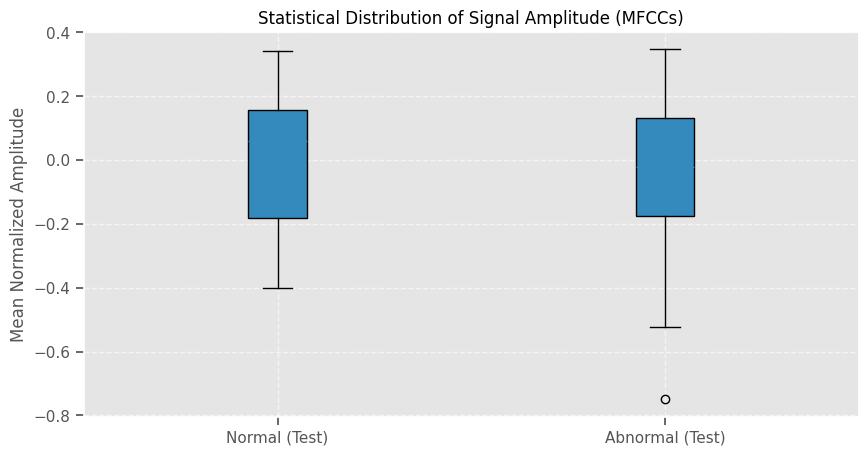

In [56]:
mean_norm = np.mean(X_test_normal_B, axis=(1, 2))
mean_abnorm = np.mean(X_test_abnormal_B, axis=(1, 2))

plt.figure(figsize=(10, 5))
plt.boxplot([mean_norm, mean_abnorm], labels=['Normal (Test)', 'Abnormal (Test)'], patch_artist=True)
plt.title("Statistical Distribution of Signal Amplitude (MFCCs)")
plt.ylabel("Mean Normalized Amplitude")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Modelling

### PCA

In [74]:
# PCA(baseline)
# Flatten Data
X_train_flat_B = X_train_B.reshape(X_train_B.shape[0], -1)
X_test_norm_flat_B = X_test_normal_B.reshape(X_test_normal_B.shape[0], -1)
X_test_abnorm_flat_B = X_test_abnormal_B.reshape(X_test_abnormal_B.shape[0], -1)

# Train PCA (95% Variance)
pca = PCA(n_components=0.95)
pca.fit(X_train_flat_B)



PCA(n_components=0.95)

In [80]:
# Reconstruct & Calculate Error
X_test_combined_B = np.concatenate([X_test_norm_flat_B, X_test_abnorm_flat_B])
X_pca_recon = pca.inverse_transform(pca.transform(X_test_combined_B))

# Error Metric: Mean Squared Error
mse_pca = np.mean(np.square(X_test_combined_B - X_pca_recon), axis=1)

# Store Results
results = {'PCA': mse_pca}
print(f" PCA: {pca.n_components_}")

 PCA: 261


### GMM

In [78]:
#GMM
X_train_mean_B = np.mean(X_train_B, axis=1)
X_test_mean_B = np.concatenate([np.mean(X_test_normal_B, axis=1), np.mean(X_test_abnormal_B, axis=1)])

# Train GMM
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(X_train_mean_B)



GaussianMixture(n_components=4, random_state=42)

In [81]:
# Score for Log-Likelihood (Higher = More Normal)
# Flip so Higher = More Abnormal (introduce a minus sign)
log_likelihood = gmm.score_samples(X_test_mean_B)
score_gmm = -log_likelihood

results['GMM'] = score_gmm
print("GMM")

GMM


### LSTM

In [83]:
# LSTM
input_dim_B = (X_train_B.shape[1], X_train_B.shape[2]) # (Time, Features)

# Architecture
inputs = layers.Input(shape=input_dim_B)
# Encoder
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(inputs)
x = layers.Bidirectional(layers.LSTM(16, return_sequences=False))(x) # Bottleneck
x = layers.RepeatVector(input_dim_B[0])(x) # Repeat for Decoder
# Decoder
x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
outputs = layers.TimeDistributed(layers.Dense(input_dim_B[1]))(x)

lstm_ae = models.Model(inputs, outputs)
lstm_ae.compile(optimizer='adam', loss='mse')

In [85]:
# Train
hist_lstm = lstm_ae.fit(
    X_train_B, X_train_B,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.8688 - val_loss: 0.8807
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.8274 - val_loss: 0.8578
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.7976 - val_loss: 0.8429
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.7823 - val_loss: 0.8349
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.7780 - val_loss: 0.8309
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.7660 - val_loss: 0.8274
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.7566 - val_loss: 0.8244
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.7568 - val_loss: 0.8198
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.7488 - val_loss: 0.8192
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.7523 - val_loss: 0.8183
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.7316 - val_loss: 0.8173
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.7491 - val_loss: 0.8155
Epoch 13/30
9

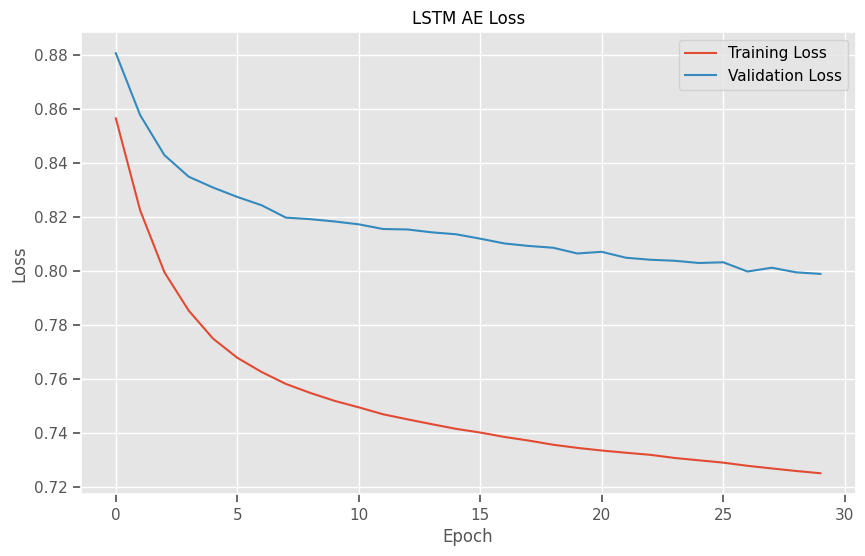

LSTM .


In [89]:
# Predict & Calculate Error
X_test_combined_B_seq = np.concatenate([X_test_normal_B, X_test_abnormal_B])
pred_lstm = lstm_ae.predict(X_test_combined_B_seq, verbose=0)
mse_lstm = np.mean(np.square(X_test_combined_B_seq - pred_lstm), axis=(1,2))

results['LSTM_AE'] = mse_lstm
plot_history(hist_lstm, "LSTM AE Loss")
print("LSTM .")

In [90]:
def plot_history(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [110]:
# save lstm model
tf.keras.models.save_model(lstm_ae, 'lstm_ae_model.h5')


### CNN Auto Encoder

In [102]:
# Expand dimensions for CNN (Time, Freq, 1)
X_train_A_exp = np.expand_dims(X_train_A, axis=-1)
X_test_norm_A_exp = np.expand_dims(X_test_normal_A, axis=-1)
X_test_abnorm_A_exp = np.expand_dims(X_test_abnormal_A, axis=-1)

# Get input shape automatically
input_shape = X_train_A_exp.shape[1:] # e.g., (313, 64, 1)

inputs = layers.Input(shape=input_shape)

# Encoder
# Padding='same' keeps dimensions predictable during downsampling
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(inputs);
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping due to the odd no of pixels
current_shape = x.shape[1:3] # e.g., (316, 64)
target_shape = input_shape[0:2] # e.g., (313, 64)

crop_height = current_shape[0] - target_shape[0]
crop_width = current_shape[1] - target_shape[1]

# Apply cropping (Top/Bottom, Left/Right)
outputs = layers.Cropping2D(cropping=((0, crop_height), (0, crop_width)))(x)

# Compile
cnn_ae = models.Model(inputs, outputs)
cnn_ae.compile(optimizer='adam', loss='mse')

In [103]:
# Train
hist_cnn = cnn_ae.fit(
    X_train_A_exp, X_train_A_exp,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.0140 - val_loss: 0.0132
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0136 - val_loss: 0.0125
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0125 - val_loss: 0.0116
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0124 - val_loss: 0.0109
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0108 - val_loss: 0.0100
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0101 - val_loss: 0.0088
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0087 - val_loss: 0.0074
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0072 - val_loss: 0.0065
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0062 - val_loss: 0.0057
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0053 - val_loss: 0.0051
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0049 - val_loss: 0.0045
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.0044 - val_loss: 0.0043
Epoch 13/30
9

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


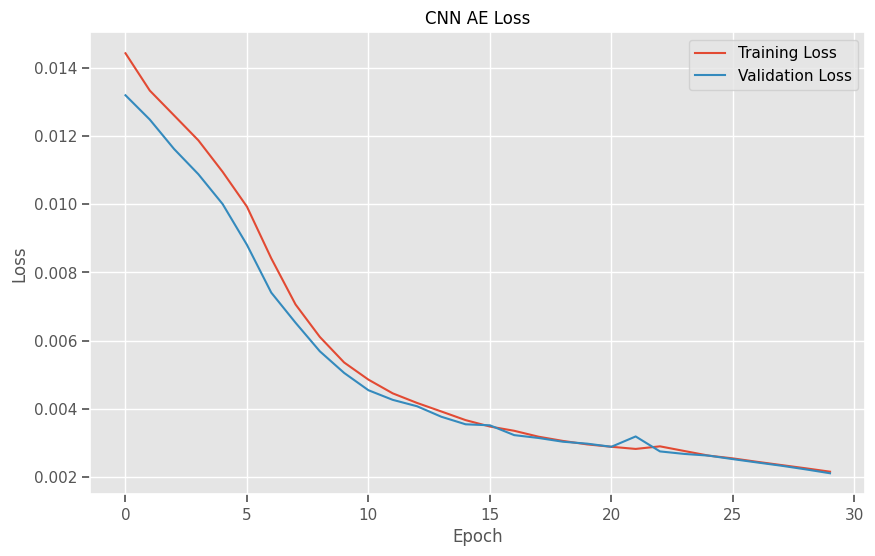

CNN .


In [104]:
# Predict & Calculate Error
X_test_combined_A = np.concatenate([X_test_norm_A_exp, X_test_abnorm_A_exp])
pred_cnn = cnn_ae.predict(X_test_combined_A, verbose=1)
mse_cnn = np.mean(np.square(X_test_combined_A - pred_cnn), axis=(1,2,3))

results['CNN_AE'] = mse_cnn
plot_history(hist_cnn, "CNN AE Loss")
print("CNN .")

## Evaluation

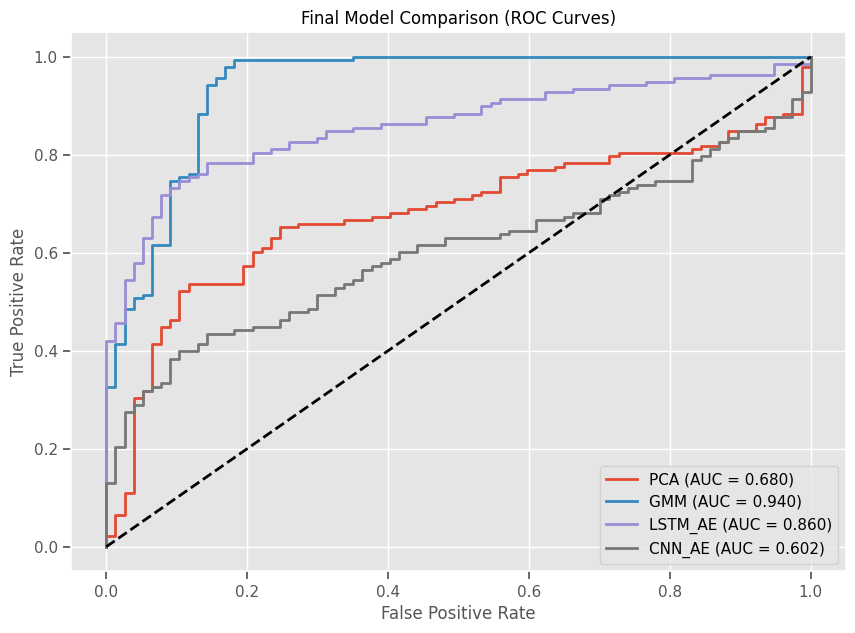

In [105]:
# ROC Curve
plt.figure(figsize=(10, 7))

# Plot the ROC for the 4 models
for name, scores in results.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Final Model Comparison (ROC Curves)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [106]:
# Pick the winner (Usually CNN or LSTM)
# We programmatically find the best AUC
best_auc = 0
winning_model = ""

for name, scores in results.items():
    current_auc = auc(*roc_curve(y_test, scores)[:2])
    if current_auc > best_auc:
        best_auc = current_auc
        winning_model = name
        winning_scores = scores

print(f"🏆 The Winning Model is: {winning_model} (AUC={best_auc:.3f})")

🏆 The Winning Model is: GMM (AUC=0.940)


In [ ]:
# # Optimal Threshold (G-Mean Geometric Mean)
# fpr, tpr, thresholds = roc_curve(y_test, winning_scores)
# gmeans = np.sqrt(tpr * (1-fpr))
# ix = np.argmax(gmeans)
# best_threshold = thresholds[ix]

# print(f"Optimal Threshold for {winning_model}: {best_threshold:.5f}")



In [ ]:
# # Generate Predictions
# y_pred = (winning_scores > best_threshold).astype(int)

# # Plot Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Normal', 'Abnormal'],
#             yticklabels=['Normal', 'Abnormal'])
# plt.title(f'Confusion Matrix ({winning_model})')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

In [111]:
# select lstm score
model_name = 'LSTM_AE'
scores = results['LSTM_AE']

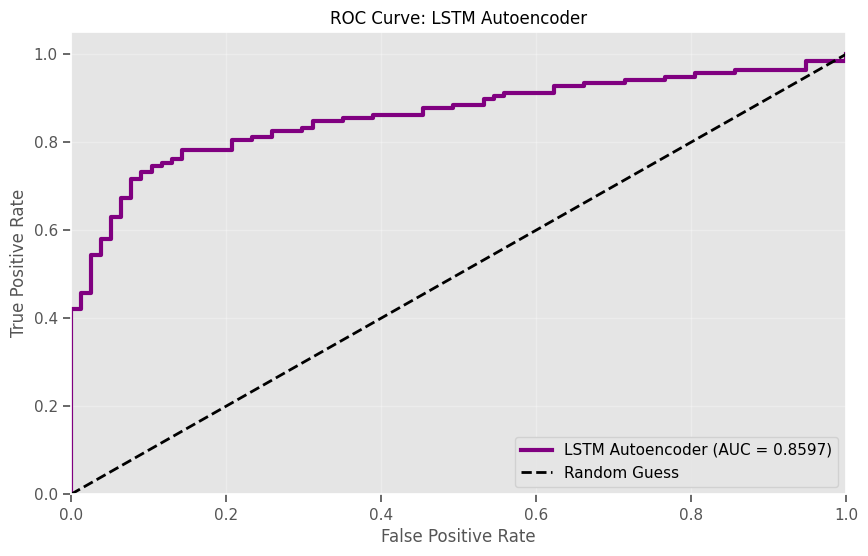

In [112]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, scores)
model_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='purple', linewidth=3, label=f'LSTM Autoencoder (AUC = {model_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: LSTM Autoencoder')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [113]:
# Threshold optimization
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]

print(f"LSTM Optimization Results:")
print(f"   - Best Threshold: {best_threshold:.6f}")
print(f"   - G-Mean Score:   {gmeans[ix]:.4f}")

LSTM Optimization Results:
   - Best Threshold: 0.894321
   - G-Mean Score:   0.8190


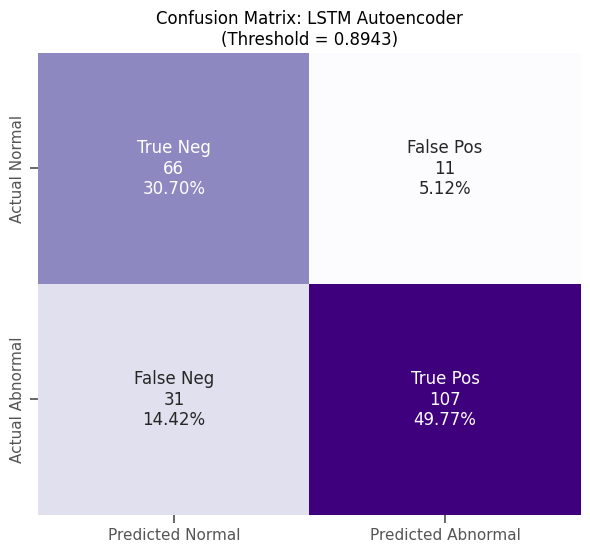

In [120]:
# Confusion matrix
y_pred = (scores > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
# Create labels for the boxes
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Purples', cbar=False,
            xticklabels=['Predicted Normal', 'Predicted Abnormal'],
            yticklabels=['Actual Normal', 'Actual Abnormal'])

plt.title(f'Confusion Matrix: LSTM Autoencoder\n(Threshold = {best_threshold:.4f})')
plt.show()

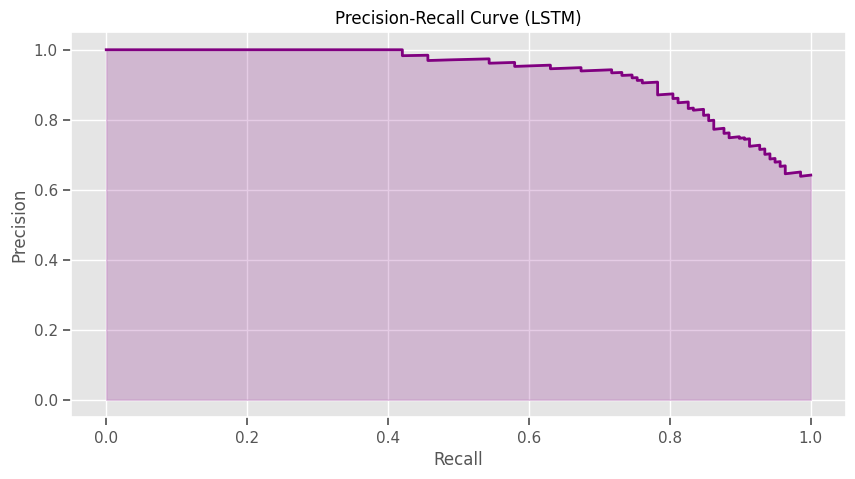

In [116]:
# Preciseion recall curve
precision, recall, _ = precision_recall_curve(y_test, scores)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, color='purple', lw=2)
plt.fill_between(recall, precision, alpha=0.2, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (LSTM)')
plt.show()

## Error Analysis

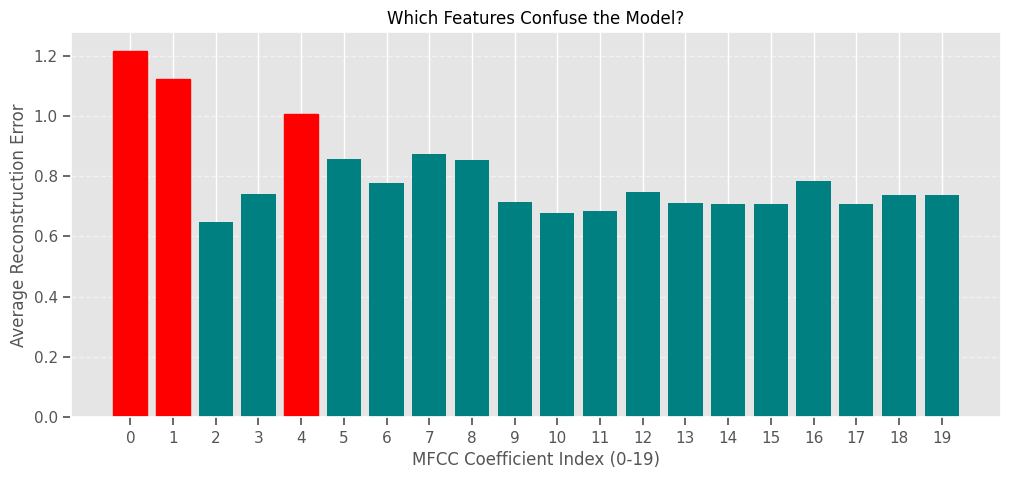

In [123]:
# Error for every MFCC coefficient
diff = np.abs(X_test_combined_B_seq - pred_lstm)

# Avg error for the 20 coefficients
avg_error_per_mfcc = np.mean(diff, axis=(0, 1))

# Visualization
plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(avg_error_per_mfcc)), avg_error_per_mfcc, color='teal')
plt.xlabel("MFCC Coefficient Index (0-19)")
plt.ylabel("Average Reconstruction Error")
plt.title("Which Features Confuse the Model?")
plt.xticks(range(len(avg_error_per_mfcc)))
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show top 3 noisy features
noisy_features = np.argsort(avg_error_per_mfcc)[-3:]
for idx in noisy_features:
    bars[idx].set_color('red')

plt.show()

## Optimization

In [126]:
# Optimization masked scoring
# create mask
mask = np.ones(20)
mask[noisy_features] = 0 # 1 = keep 0= ignore
mask = mask.reshape(1, 1, -1)

# Recalculate error with mask
squared_diff = np.square(X_test_combined_B_seq - pred_lstm)
masked_diff = squared_diff * mask # Zero out the noisy columns

# Normalize
mse_refined = np.sum(masked_diff, axis=(1, 2)) / np.sum(mask)

## Re-evaluation

In [127]:
# Compare vs original performance
# Original AUC with All features
fpr_orig, tpr_orig, _ = roc_curve(y_test, results['LSTM_AE'])
auc_orig = auc(fpr_orig, tpr_orig)

# Refined AUC with Masked features
fpr_new, tpr_new, _ = roc_curve(y_test, mse_refined)
auc_new = auc(fpr_new, tpr_new)

# Results
print(f"Original AUC: {auc_orig:.4f}")
print(f"Refined AUC:  {auc_new:.4f}")
delta = auc_new - auc_orig
print(f"Impact:       {delta:+.4f}")

Original AUC: 0.8597
Refined AUC:  0.7327
Impact:       -0.1270


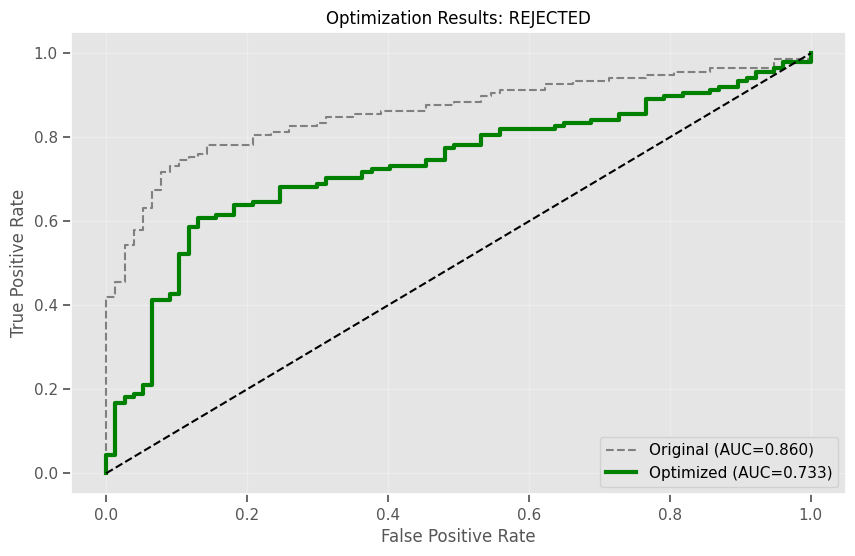

In [128]:
# Visual Comparison
plt.figure(figsize=(10, 6))
plt.plot(fpr_orig, tpr_orig, linestyle='--', color='gray', label=f'Original (AUC={auc_orig:.3f})')
plt.plot(fpr_new, tpr_new, linewidth=3, color='green', label=f'Optimized (AUC={auc_new:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"Optimization Results: {'SUCCESS' if delta > 0 else 'REJECTED'}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

Saving the model

In [132]:
# Save the model
model_filename = "mimii_lstm_autoencoder.h5"
lstm_ae.save(model_filename)
print(f"Model Saved:{model_filename}")

# Save the Scaler
scaler_filename = "mfcc_scaler.pkl"
joblib.dump(scaler_B, scaler_filename)
print(f"Scaler:{scaler_filename}")


Model Saved:mimii_lstm_autoencoder.h5
Scaler:mfcc_scaler.pkl
